In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10



In [2]:
df = pd.read_csv('LightBeer.csv')
display(df.head(3))


,household,upc_description,quantity,beer_brand,beer_spend,beer_floz,price_floz,container_descr,promotion,market,...,age,employment,degree,occupation,ethnic,microwave,dishwasher,tvcable,singlefamilyhome,npeople
0,2000946,BUD LT BR CN 12P,1,BUD LIGHT,8.14,144.0,0.056528,CAN,False,RURAL ILLINOIS,...,50+,none,Grad,none/retired/student,white,True,True,premium,False,1
1,2003036,BUD LT BR CN 24P,1,BUD LIGHT,17.48,288.0,0.060694,CAN,False,ATLANTA,...,50+,full,College,clerical/sales/service,white,True,True,basic,True,2
2,2003036,BUD LT BR CN 24P,2,BUD LIGHT,33.92,576.0,0.058889,CAN,False,ATLANTA,...,50+,full,College,clerical/sales/service,white,True,True,basic,True,2


🎯 ANALIZANDO EL TARGET: beer_spend
📊 ESTADÍSTICAS CLAVE:
   Media: $13.78
   Mediana: $12.99
   Desviación estándar: $8.72
   Mínimo: $0.51
   Máximo: $159.13
   Coeficiente de variación: 0.633
    VARIABILIDAD MODERADA - Modelo puede ser inestable


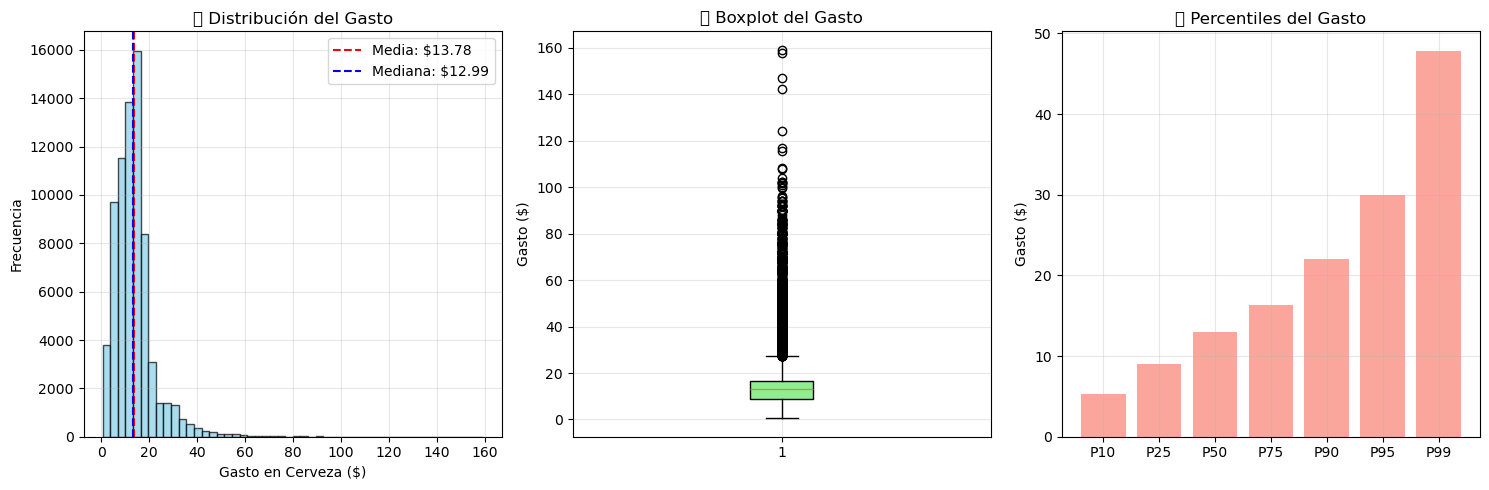


🚨 OUTLIERS EN EL TARGET:
   Número de outliers: 4,631 (6.3%)
   Rango normal: $-2.14 - $27.49
    MUCHOS OUTLIERS - Considera usar modelos robustos (RandomForest)


In [3]:
print("🎯 ANALIZANDO EL TARGET: beer_spend")
print("=" * 50)

target = df['beer_spend']
print(f"📊 ESTADÍSTICAS CLAVE:")
print(f"   Media: ${target.mean():.2f}")
print(f"   Mediana: ${target.median():.2f}")
print(f"   Desviación estándar: ${target.std():.2f}")
print(f"   Mínimo: ${target.min():.2f}")
print(f"   Máximo: ${target.max():.2f}")

cv = target.std() / target.mean()
print(f"   Coeficiente de variación: {cv:.3f}")

if cv > 1:
    print("    ALTA VARIABILIDAD - El modelo tendrá dificultades")
elif cv > 0.5:
    print("    VARIABILIDAD MODERADA - Modelo puede ser inestable")
else:
    print("    BAJA VARIABILIDAD - Modelo debería ser estable")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(target, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(target.mean(), color='red', linestyle='--', label=f'Media: ${target.mean():.2f}')
plt.axvline(target.median(), color='blue', linestyle='--', label=f'Mediana: ${target.median():.2f}')
plt.title('📊 Distribución del Gasto')
plt.xlabel('Gasto en Cerveza ($)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.boxplot(target, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('📦 Boxplot del Gasto')
plt.ylabel('Gasto ($)')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
percentiles = [10, 25, 50, 75, 90, 95, 99]
values = [target.quantile(p/100) for p in percentiles]
plt.bar(range(len(percentiles)), values, color='salmon', alpha=0.7)
plt.xticks(range(len(percentiles)), [f'P{p}' for p in percentiles])
plt.title('📈 Percentiles del Gasto')
plt.ylabel('Gasto ($)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)
IQR = Q3 - Q1
outliers = target[(target < Q1 - 1.5*IQR) | (target > Q3 + 1.5*IQR)]

print(f"\n🚨 OUTLIERS EN EL TARGET:")
print(f"   Número de outliers: {len(outliers):,} ({len(outliers)/len(df)*100:.1f}%)")
print(f"   Rango normal: ${Q1 - 1.5*IQR:.2f} - ${Q3 + 1.5*IQR:.2f}")

if len(outliers) > len(df) * 0.05:
    print("    MUCHOS OUTLIERS - Considera usar modelos robustos (RandomForest)")
else:
    print("   POCOS OUTLIERS - Modelos lineales funcionarán bien")


🔗 ANALIZANDO RELACIONES CLAVE
📊 CORRELACIONES CON EL TARGET:
   quantity ↔ beer_spend: 0.3661 ⚡ CORRELACIÓN MODERADA
   beer_floz ↔ beer_spend: 0.8563 🔥 CORRELACIÓN FUERTE
   price_floz ↔ beer_spend: -0.1253 💤 CORRELACIÓN DÉBIL


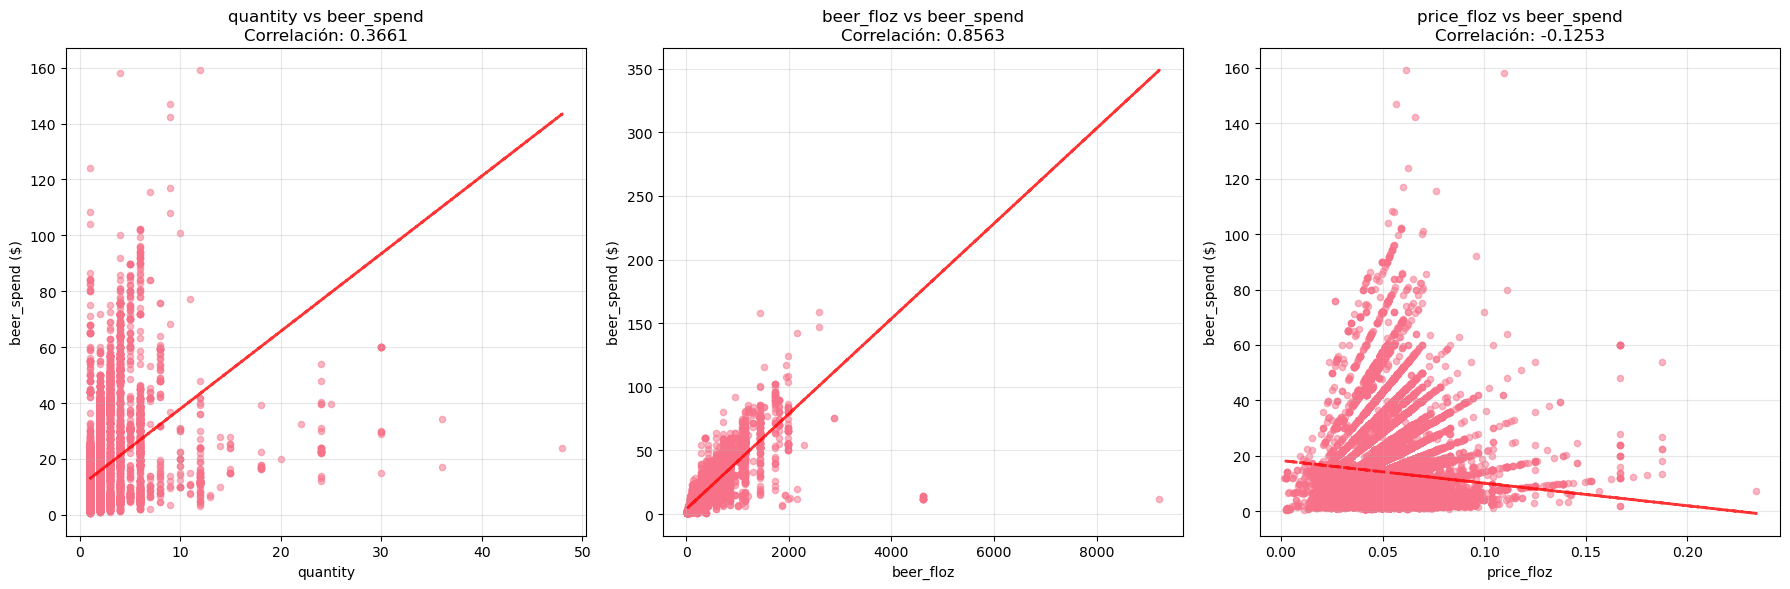


💡 INTERPRETACIÓN PARA TU MODELO:
   🏆 Mejor predictor numérico: beer_floz (r=0.8563)
   ✅ Tu modelo debería funcionar MUY BIEN


In [4]:
print("🔗 ANALIZANDO RELACIONES CLAVE")
print("=" * 50)

numeric_features = ['quantity', 'beer_floz', 'price_floz']

print("📊 CORRELACIONES CON EL TARGET:")
for feature in numeric_features:
    corr = df[feature].corr(df['beer_spend'])
    print(f"   {feature} ↔ beer_spend: {corr:.4f}", end="")
    
    if abs(corr) > 0.7:
        print(" 🔥 CORRELACIÓN FUERTE")
    elif abs(corr) > 0.3:
        print(" ⚡ CORRELACIÓN MODERADA")
    else:
        print(" 💤 CORRELACIÓN DÉBIL")

plt.figure(figsize=(18, 6))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    
    plt.scatter(df[feature], df['beer_spend'], alpha=0.5, s=20)
    
    z = np.polyfit(df[feature], df['beer_spend'], 1)
    p = np.poly1d(z)
    plt.plot(df[feature], p(df[feature]), "r--", alpha=0.8, linewidth=2)
    
    corr = df[feature].corr(df['beer_spend'])
    plt.title(f'{feature} vs beer_spend\nCorrelación: {corr:.4f}')
    plt.xlabel(feature)
    plt.ylabel('beer_spend ($)')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACIÓN PARA TU MODELO:")
best_feature = max(numeric_features, key=lambda x: abs(df[x].corr(df['beer_spend'])))
best_corr = df[best_feature].corr(df['beer_spend'])
print(f"   🏆 Mejor predictor numérico: {best_feature} (r={best_corr:.4f})")

if abs(best_corr) > 0.8:
    print("   ✅ Tu modelo debería funcionar MUY BIEN")
elif abs(best_corr) > 0.5:
    print("   ✅ Tu modelo debería funcionar BIEN")
elif abs(best_corr) > 0.3:
    print("   ⚠️ Tu modelo será MODERADO - necesitas más features")
else:
    print("   ❌ Relaciones débiles - modelo será DIFÍCIL")


🏷️ ANALIZANDO VARIABLES CATEGÓRICAS

📊 INCOME:
   Gasto promedio por categoría:
      200k+: $15.12 (n=723.0)
      100-200k: $14.79 (n=8,267.0)
      60-100k: $13.68 (n=23,494.0)
   Variabilidad entre grupos: 0.45
   💤 POCA DIFERENCIA - Variable menos importante

📊 AGE:
   Gasto promedio por categoría:
      50+: $13.96 (n=48,003.0)
      40-49: $13.68 (n=18,435.0)
      30-39: $12.82 (n=5,846.0)
   Variabilidad entre grupos: 0.67
   💤 POCA DIFERENCIA - Variable menos importante

📊 BUYERTYPE:
   Gasto promedio por categoría:
      married: $13.97 (n=50,299.0)
      male: $13.41 (n=13,224.0)
      female: $13.29 (n=9,592.0)
   Variabilidad entre grupos: 0.09
   💤 POCA DIFERENCIA - Variable menos importante

📊 PROMOTION:
   Gasto promedio por categoría:
      True: $15.36 (n=14,552.0)
      False: $13.38 (n=58,563.0)
   Variabilidad entre grupos: 0.98
   💤 POCA DIFERENCIA - Variable menos importante


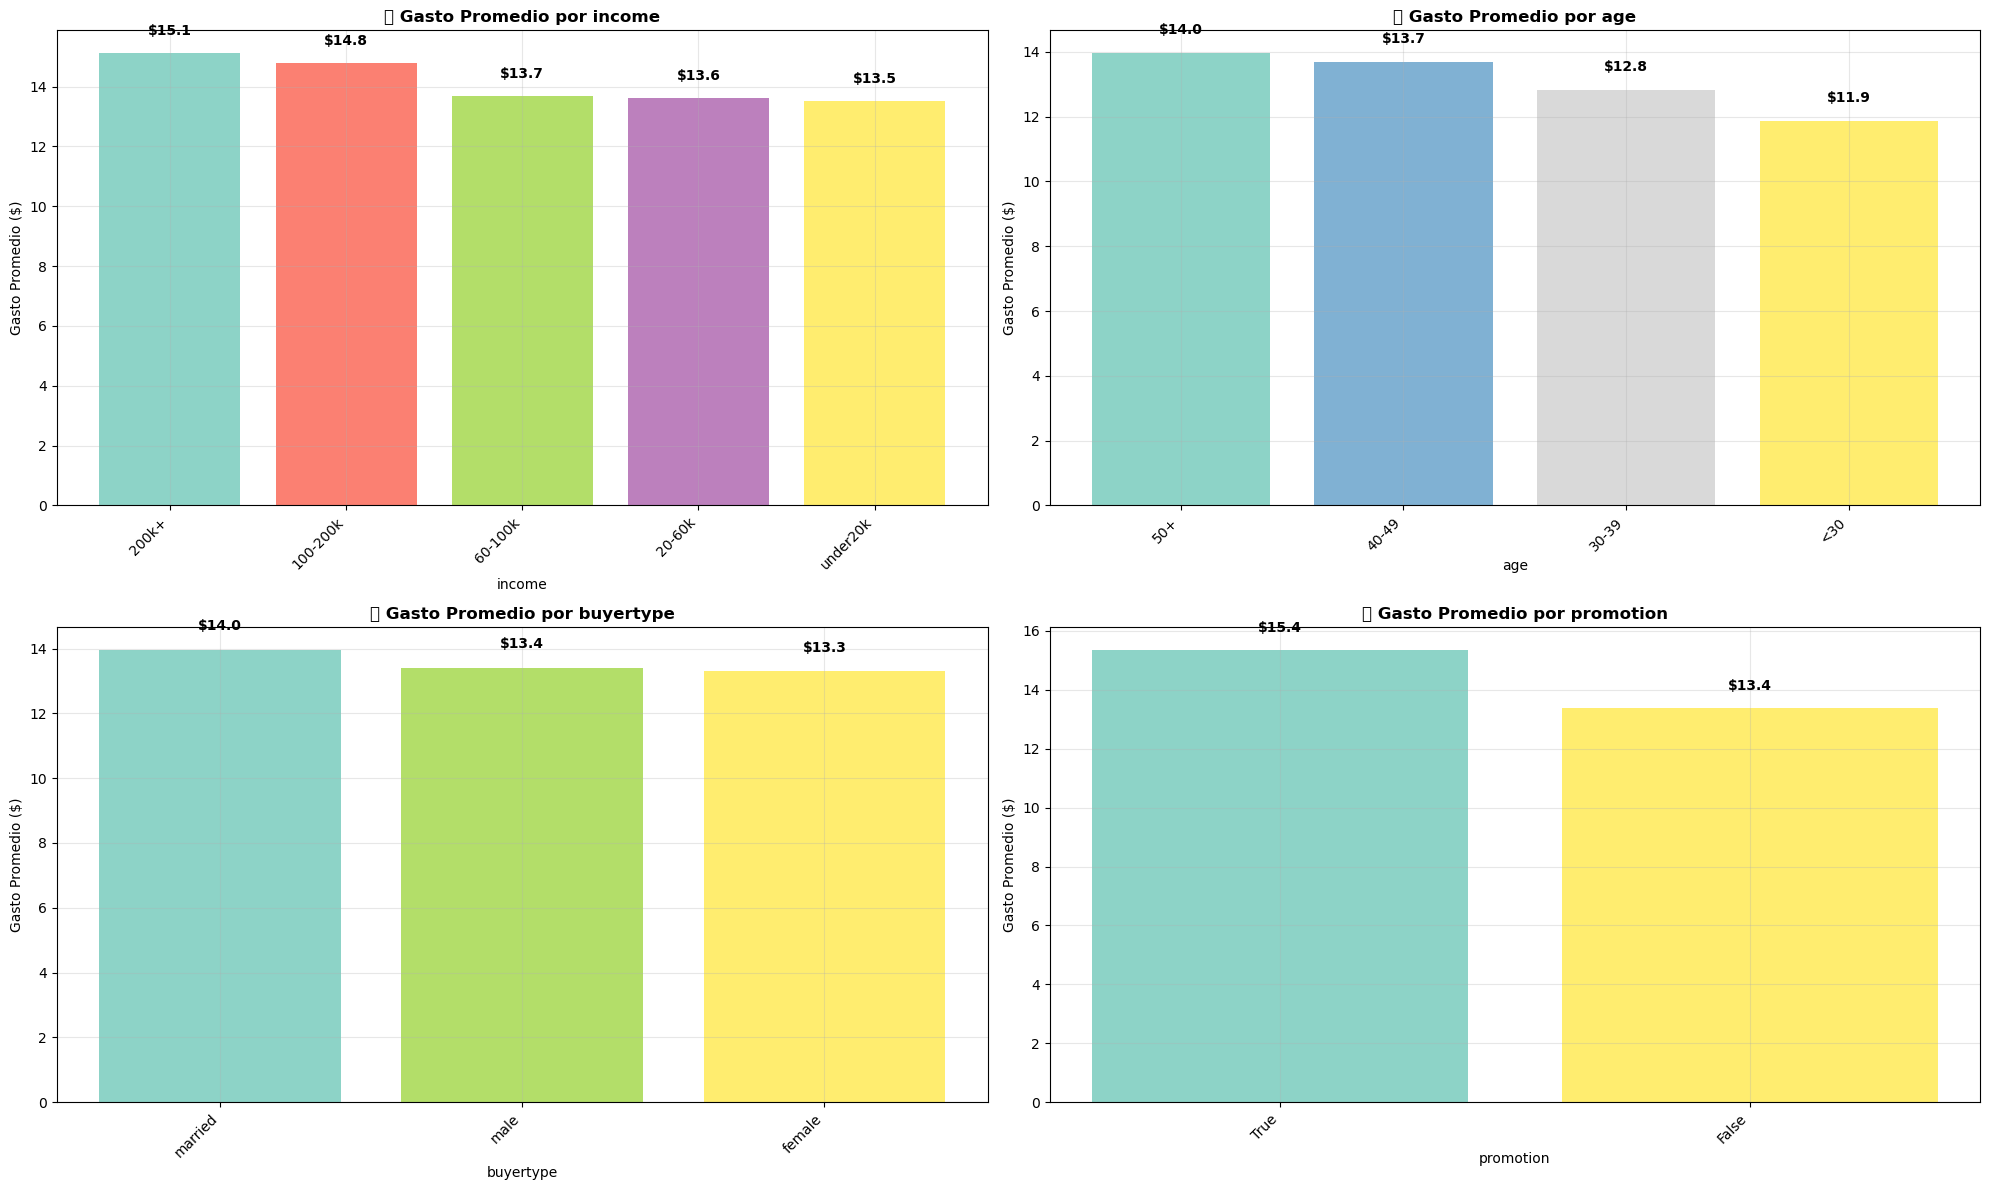


💡 RECOMENDACIONES PARA TU MODELO:
   🎯 Variables categóricas con mayor impacto:
      1. promotion: Impacto = 0.98
      2. age: Impacto = 0.67
      3. income: Impacto = 0.45
      4. buyertype: Impacto = 0.09

   🏆 Variable más importante: promotion
   💡 Usa LabelEncoder o OneHotEncoder para estas variables


In [10]:
print("🏷️ ANALIZANDO VARIABLES CATEGÓRICAS")
print("=" * 50)

categorical_features = ['income', 'age', 'buyertype', 'promotion']

# Análisis de cada variable categórica
for feature in categorical_features:
    print(f"\n📊 {feature.upper()}:")
    
    # Estadísticas por categoría
    stats_by_category = df.groupby(feature)['beer_spend'].agg(['mean', 'count', 'std']).round(2)
    stats_by_category = stats_by_category.sort_values('mean', ascending=False)
    
    print("   Gasto promedio por categoría:")
    for category, row in stats_by_category.head(3).iterrows():
        print(f"      {category}: ${row['mean']:.2f} (n={row['count']:,})")
    
    # Calcular variabilidad entre grupos
    overall_mean = df['beer_spend'].mean()
    group_means = df.groupby(feature)['beer_spend'].mean()
    between_group_var = np.var(group_means)
    
    print(f"   Variabilidad entre grupos: {between_group_var:.2f}")
    if between_group_var > 10:
        print("   🔥 ALTA DIFERENCIA - Esta variable será MUY ÚTIL")
    elif between_group_var > 2:
        print("   ⚡ DIFERENCIA MODERADA - Variable útil")
    else:
        print("   💤 POCA DIFERENCIA - Variable menos importante")

# Visualización de las variables más importantes
plt.figure(figsize=(20, 12))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    
    # Calcular medias por categoría
    category_means = df.groupby(feature)['beer_spend'].mean().sort_values(ascending=False)
    
    # Gráfico de barras
    bars = plt.bar(range(len(category_means)), category_means.values, 
                   color=plt.cm.Set3(np.linspace(0, 1, len(category_means))))
    
    plt.title(f'💰 Gasto Promedio por {feature}', fontweight='bold')
    plt.xlabel(feature)
    plt.ylabel('Gasto Promedio ($)')
    plt.xticks(range(len(category_means)), category_means.index, rotation=45, ha='right')
    plt.grid(alpha=0.3)
    
    # Agregar valores en las barras
    for bar, value in zip(bars, category_means.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'${value:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 RECOMENDACIONES PARA TU MODELO:")
print("   🎯 Variables categóricas con mayor impacto:")

# Calcular impacto de cada variable
impacts = {}
for feature in categorical_features:
    group_means = df.groupby(feature)['beer_spend'].mean()
    impact = np.var(group_means)
    impacts[feature] = impact

# Ordenar por impacto
sorted_impacts = sorted(impacts.items(), key=lambda x: x[1], reverse=True)

for i, (feature, impact) in enumerate(sorted_impacts, 1):
    print(f"      {i}. {feature}: Impacto = {impact:.2f}")

print(f"\n   🏆 Variable más importante: {sorted_impacts[0][0]}")
print("   💡 Usa LabelEncoder o OneHotEncoder para estas variables")


In [8]:
print("📈 ESTADÍSTICAS DESCRIPTIVAS:")
df.describe()


📈 ESTADÍSTICAS DESCRIPTIVAS:


,household,quantity,beer_spend,beer_floz,price_floz
count,7.311500e+04,73115.000000,73115.000000,73115.000000,73115.000000
mean,1.740772e+07,1.317527,13.777683,265.926853,0.055951
std,1.158215e+07,1.149649,8.722942,199.522488,0.013417
min,2.000235e+06,1.000000,0.510000,12.000000,0.001315
25%,8.223438e+06,1.000000,8.970000,144.000000,0.046306
50%,8.413624e+06,1.000000,12.990000,216.000000,0.055509
75%,3.017132e+07,1.000000,16.380000,360.000000,0.063750
max,3.044072e+07,48.000000,159.130000,9216.000000,0.234063


In [11]:
print("🔎 ANÁLISIS DE CALIDAD DE DATOS")
print("-" * 40)

missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Columna': missing_data.index,
    'Valores_Faltantes': missing_data.values,
    'Porcentaje': missing_percent.values
})

missing_info = missing_df[missing_df['Valores_Faltantes'] > 0]

if missing_info.empty:
    print("No hay valores faltantes en el dataset")
else:
    print(" Valores faltantes encontrados:")
    display(missing_info)


data_types = df.dtypes.value_counts()
print(data_types)


🔎 ANÁLISIS DE CALIDAD DE DATOS
----------------------------------------
No hay valores faltantes en el dataset
object     13
bool        6
float64     3
int64       2
Name: count, dtype: int64


In [6]:
print("📊 ANÁLISIS DE VARIABLES NUMÉRICAS")
print("-" * 40)

# Identificar variables numéricas principales
numeric_cols = ['quantity', 'beer_spend', 'beer_floz', 'price_floz']

# Estadísticas detalladas
print("Estadísticas detalladas de variables numéricas clave:")
for col in numeric_cols:
    print(f"\n{col.upper()}:")
    print(f"  📊 Media: {df[col].mean():.4f}")
    print(f"  📊 Mediana: {df[col].median():.4f}")
    print(f"  📊 Desv. Estándar: {df[col].std():.4f}")
    print(f"  📊 Mínimo: {df[col].min():.4f}")
    print(f"  📊 Máximo: {df[col].max():.4f}")
    print(f"  📊 Q1 (25%): {df[col].quantile(0.25):.4f}")
    print(f"  📊 Q3 (75%): {df[col].quantile(0.75):.4f}")
    print(f"  📊 Rango IQR: {df[col].quantile(0.75) - df[col].quantile(0.25):.4f}")


📊 ANÁLISIS DE VARIABLES NUMÉRICAS
----------------------------------------
Estadísticas detalladas de variables numéricas clave:

QUANTITY:
  📊 Media: 1.3175
  📊 Mediana: 1.0000
  📊 Desv. Estándar: 1.1496
  📊 Mínimo: 1.0000
  📊 Máximo: 48.0000
  📊 Q1 (25%): 1.0000
  📊 Q3 (75%): 1.0000
  📊 Rango IQR: 0.0000

BEER_SPEND:
  📊 Media: 13.7777
  📊 Mediana: 12.9900
  📊 Desv. Estándar: 8.7229
  📊 Mínimo: 0.5100
  📊 Máximo: 159.1300
  📊 Q1 (25%): 8.9700
  📊 Q3 (75%): 16.3800
  📊 Rango IQR: 7.4100

BEER_FLOZ:
  📊 Media: 265.9269
  📊 Mediana: 216.0000
  📊 Desv. Estándar: 199.5225
  📊 Mínimo: 12.0000
  📊 Máximo: 9216.0000
  📊 Q1 (25%): 144.0000
  📊 Q3 (75%): 360.0000
  📊 Rango IQR: 216.0000

PRICE_FLOZ:
  📊 Media: 0.0560
  📊 Mediana: 0.0555
  📊 Desv. Estándar: 0.0134
  📊 Mínimo: 0.0013
  📊 Máximo: 0.2341
  📊 Q1 (25%): 0.0463
  📊 Q3 (75%): 0.0638
  📊 Rango IQR: 0.0174



---


### **H1: Predicción Excelente con beer_floz**
**Hipótesis**: El modelo tendrá un rendimiento excelente (R² > 0.7) porque `beer_floz` tiene una correlación muy fuerte (0.8563) con el gasto.

**Justificación**: 
- La correlación de 0.8563 sugiere que el 73% de la varianza del gasto se explica solo por las onzas de cerveza
- Relación lógica: más cerveza = más gasto


---


---

### **H3: Las promociones son el factor categórico más importante**
**Hipótesis**: La variable `promotion` será la más influyente entre las categóricas para predecir el gasto.

**Justificación**:
- Mayor impacto entre categóricas (0.98)
- Diferencia clara: Con promoción $15.36 vs Sin promoción $13.38
- Diferencia de ~$2 es significativa


---

### **H4: Variables demográficas tendrán poco impacto**
**Hipótesis**: `income`, `age`, y `buyertype` contribuirán poco al modelo debido a su bajo poder predictivo.

**Justificación**:
- Impactos bajos: income (0.45), age (0.67), buyertype (0.09)
- Diferencias pequeñas entre categorías
- Poca variabilidad entre grupos








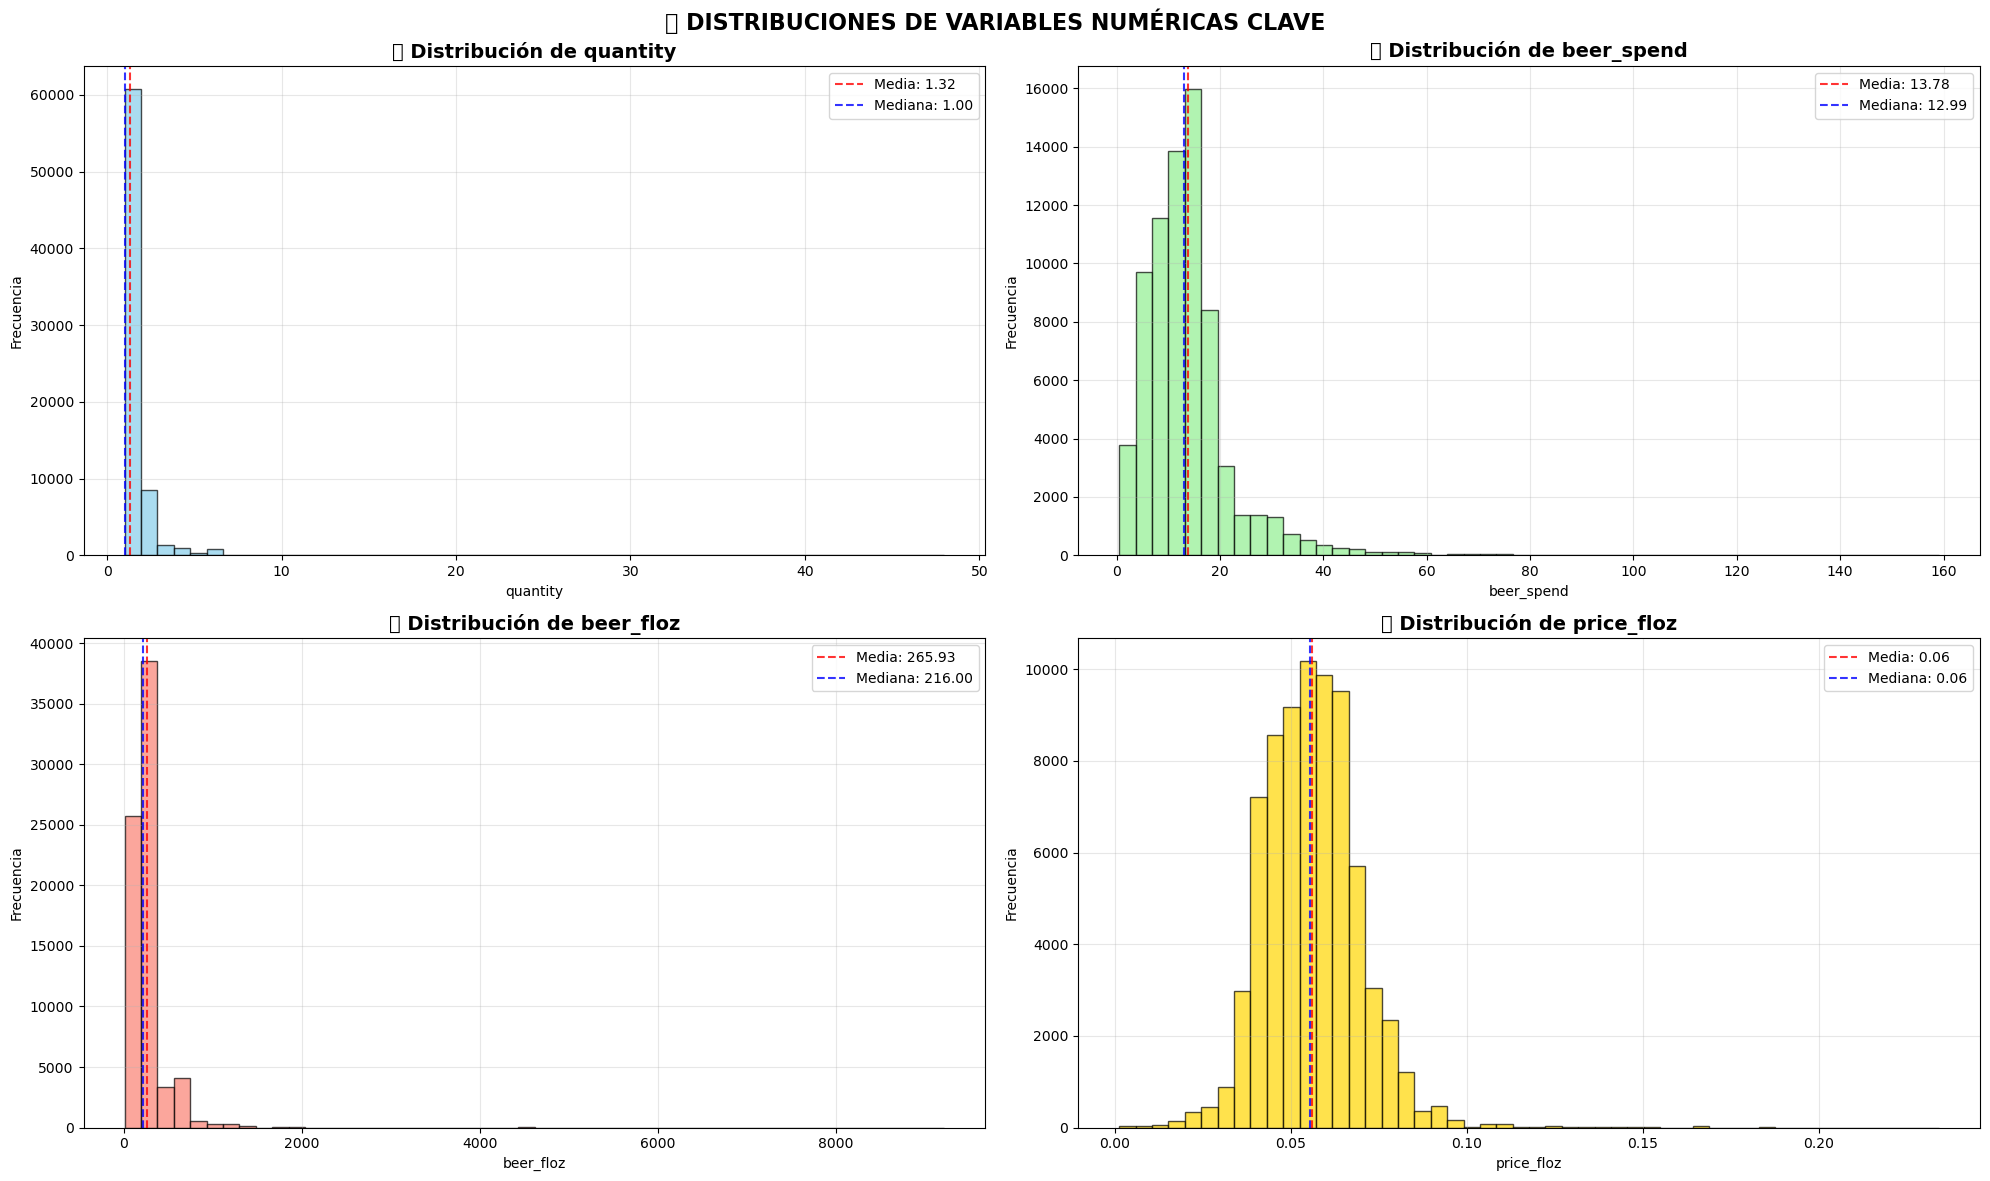

In [ ]:
plt.figure(figsize=(20, 12))
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    plt.hist(df[col], bins=50, alpha=0.7, color=colors[i-1], edgecolor='black')
    plt.title(f'📊 Distribución de {col}', fontsize=14, fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(alpha=0.3)
    
    plt.axvline(df[col].mean(), color='red', linestyle='--', alpha=0.8, label=f'Media: {df[col].mean():.2f}')
    plt.axvline(df[col].median(), color='blue', linestyle='--', alpha=0.8, label=f'Mediana: {df[col].median():.2f}')
    plt.legend()

plt.suptitle('🍺 DISTRIBUCIONES DE VARIABLES NUMÉRICAS CLAVE', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


🔗 ANÁLISIS DE CORRELACIONES
----------------------------------------
📊 Matriz de correlación:


,quantity,beer_spend,beer_floz,price_floz
quantity,1.0000,0.3661,0.3691,0.0215
beer_spend,0.3661,1.0000,0.8563,-0.1253
beer_floz,0.3691,0.8563,1.0000,-0.4114
price_floz,0.0215,-0.1253,-0.4114,1.0000


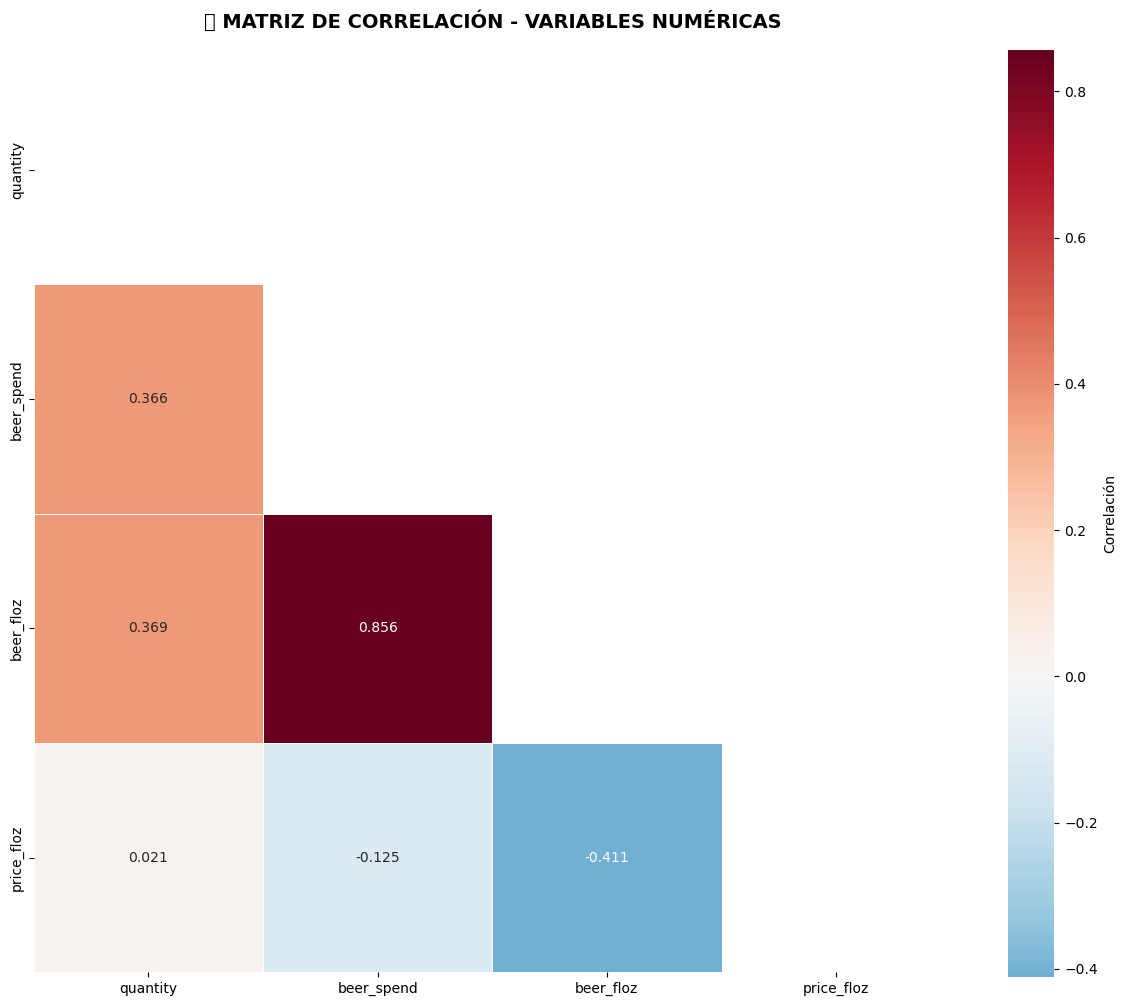

In [8]:
print("🔗 ANÁLISIS DE CORRELACIONES")
print("-" * 40)

# Matriz de correlación para variables numéricas
correlation_matrix = df[numeric_cols].corr()
print("📊 Matriz de correlación:")
display(correlation_matrix.round(4))

# Heatmap de correlaciones
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True, 
            fmt='.3f', 
            cbar_kws={'label': 'Correlación'},
            mask=mask,
            linewidths=0.5)

plt.title('🔗 MATRIZ DE CORRELACIÓN - VARIABLES NUMÉRICAS', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [ ]:
print("🏷️ ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("-" * 40)

# Variables categóricas más importantes
categorical_cols = ['beer_brand', 'container_descr', 'promotion', 'market', 
                   'buyertype', 'income', 'age', 'employment', 'degree', 'ethnic']

# Análisis detallado de cada variable categórica
for col in categorical_cols:
    print(f"\n🏷️ {col.upper()}:")
    value_counts = df[col].value_counts()
    print(f"   Valores únicos: {df[col].nunique()}")
    print(f"  📊 Valor más frecuente: {value_counts.index[0]} ({value_counts.iloc[0]:,} veces)")
    print(f"  📊 Top 5 valores:")
    for idx, (val, count) in enumerate(value_counts.head().items()):
        percentage = count/len(df)*100
        print(f"      {idx+1}. {val}: {count:,} ({percentage:.1f}%)")


🏷️ ANÁLISIS DE VARIABLES CATEGÓRICAS
----------------------------------------

🏷️ BEER_BRAND:
  📊 Valores únicos: 5
  📊 Valor más frecuente: BUD LIGHT (21,592 veces)
  📊 Top 5 valores:
      1. BUD LIGHT: 21,592 (29.5%)
      2. MILLER LITE: 17,159 (23.5%)
      3. COORS LIGHT: 13,074 (17.9%)
      4. NATURAL LIGHT: 12,616 (17.3%)
      5. BUSCH LIGHT: 8,674 (11.9%)

🏷️ CONTAINER_DESCR:
  📊 Valores únicos: 7
  📊 Valor más frecuente: CAN (53,015 veces)
  📊 Top 5 valores:
      1. CAN: 53,015 (72.5%)
      2. NON REFILLABLE BOTTLE: 19,095 (26.1%)
      3. NON REFILLABLE BOTTLE PLASTIC: 543 (0.7%)
      4. NON REFILLABLE BOTTLE ALUMINUM: 186 (0.3%)
      5. REFILLABLE BOTTLE: 156 (0.2%)

🏷️ PROMOTION:
  📊 Valores únicos: 2
  📊 Valor más frecuente: False (58,563 veces)
  📊 Top 5 valores:
      1. False: 58,563 (80.1%)
      2. True: 14,552 (19.9%)

🏷️ MARKET:
  📊 Valores únicos: 92
  📊 Valor más frecuente: TAMPA (3,287 veces)
  📊 Top 5 valores:
      1. TAMPA: 3,287 (4.5%)
      2. MIAMI: 

## Respuestas Sección 1: Parte teórica

### 1. P-values en regresión lineal

**1. En los p-values que estimamos al hacer una regresion lineal, ¿que representan? ¿Que pasa si tengo un p-value de 0.01? Justifique su respuesta.**

Los P-values en una regresion lineal nos ayuda a medir que tan probable es el efecto estimado oo que tanto impacto una avriable puede causar si su efecto fuera 0 o su valor sea cero, es decir cual es el efecto que puede dar una varibale si esta misma no aportara nada
**P-value de 0.01:**
Con un P-value de 0.01 dice que si la variable fuera 0 seria un desequilibrio muy grande en nuestros resultados es decir habria un sesgo importante 




**2. Explica en tus propias palabras que hace un k-fold cross validation y que problema ataca.**

**¿Qué hace?**
Parte sus datos en k pedazos iguales. Estop genera un promedio de rendimiento mas confiable no depende de una sola ronda

**¿Qué problema ataca?**
El principal problema que ataca esto es el overfitting ya que si el modelo llega a tener esto el dividir los datos en varias veces puede darnos diferentes pruebas y asi no recaer en un solo set de entrenamietno




**3. En los siguientes enunciados escribe si es verdadero o falso y justifica:**

 "En una regresión logística: Un valor predicho cercano a 0.5 indica alta certeza en la clasificación."


**FALSO.** Un valor cercano a 0.5 indica baja certeza en la clasificación. El modelo está "indeciso" entre las dos clases ademas como es una clasificacion binaria pues un valor apuntado en medio indica baja certeza

"En el bias-variance tradeoff: Un modelo con muy bajo sesgo tiende a sobreajustarse a los datos de entrenamiento."


**VERDADERO.** 
Un modelo con muy bajo sesgo es muy flexible y cuando le damos datos nuevos tiende a tner overfitting precisamente porque se sobre ajusta el modelo y pues puede haber pocos datos o una poca regularizacion con los daton nuevos que se metieron




**4. ¿Que problema puede surgir si las variables independientes estan altamente correlacionadas entre sı en una regresion lineal multiple? ¿Que tecnica puedes utilizar para diagnosticar este problema?**

Uno de los principales problemas que logro identifixar al tener variables altamente correlacionadas, es que va a ser dificil para el modelo interpretar que varibale importa y va a ser muy sensible a pequeños cambios

Se puede diagnosticar con una matriz de correlacion si es > 8 es muy identica




**5. Un modelo para detectar fraude bancario tiene una precisicion del 95% y un recall del 20%. ¿Que esta pasando con este modelo? ¿Que consecuencias podria tener en la vida real?**

Que el modelo obtenga solo el 20 % es muy grave ya que de 100 fraudes reales el modelo solo detecta 20 como fraude estos es muy grave ya que estamos teniendo falsos negativos 

EL problema puede ser a que este entrenado para evitar falsos positivos, y como obtinene demasiados casi no se equivoca


Es muy grave en la vida real porque hay muchso fraudes no detectados hay mucho dinero de por medi oy el banco puede aceptar los cargos que se consideran fraude


## Respuestas Sección  2: Parte Practica
Los datos consisten en 73,115 observaciones de compras de cerveza light en Estados Unidos. Estas observaciones provienen
de la base de datos Nielsen Home-Scan.


**Descripcion del archivo lightbeer.csv:.** 

• household: identificador del hogar comprador
• upc description: detalles del producto comprado (por ejemplo, un paquete de 6)
• quantity: n´umero de art´ıculos comprados
• beer brand: Bud Light, Busch Light, Coors Light, Miller Lite o Natural Light
• beer spend: valor total en d´olares de la compra
• beer floz: volumen total de cerveza, en onzas l´ıquidas
• price floz: precio por onza l´ıquida (es decir, beer spend / beer floz)
• container descr: tipo de envase
• promotion: si el producto fue promocionado (mediante cup´on u otro m´etodo)
• market: mercado Scantrack (o estado si es zona rural)
• Datos demogr´aficos: tipo de comprador (pareja casada, hombre o mujer), ingresos, ocupaci´on, educaci´on, edad
y si el hogar tiene lavavajillas o microondas





## Instrucciones:


R² Test: 0.8524
RMSE Test: $3.32

Top 5 variables más importantes:
                   Feature  Coefficient
2               price_floz   181.748655
3        promotion_encoded     0.665069
8  container_descr_encoded    -0.335221
7       beer_brand_encoded    -0.148247
6        buyertype_encoded     0.130476


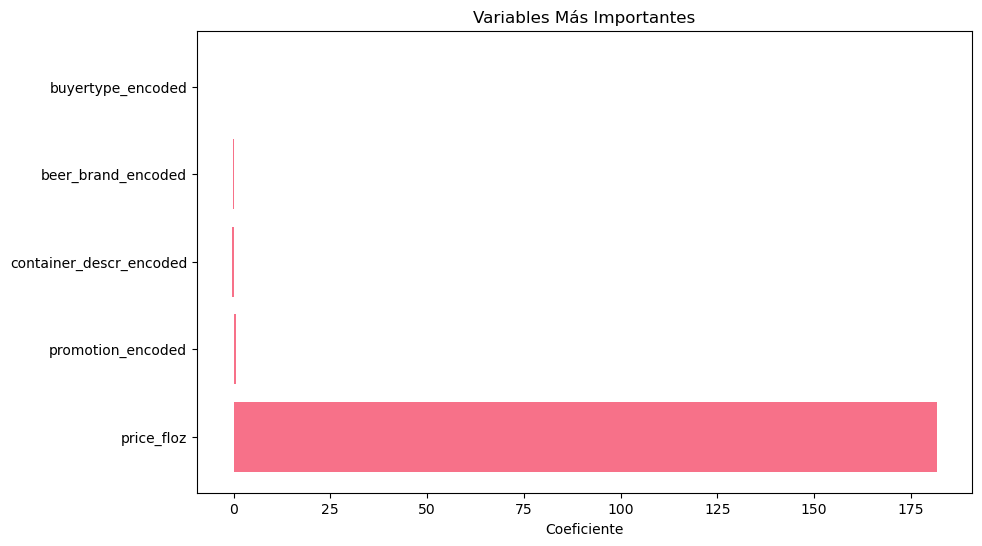

In [ ]:
# 1. Elabora una regresion lineal multiple con beer spend y determina cuales son las variables mas importantes.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np

¿df_model = df.copy()

¿numeric_features = ['quantity', 'beer_floz', 'price_floz']
categorical_features = ['promotion', 'income', 'age', 'buyertype', 'beer_brand', 'container_descr']

for feature in categorical_features:
    le = LabelEncoder()
    df_model[feature + '_encoded'] = le.fit_transform(df_model[feature])

features = numeric_features + [f + '_encoded' for f in categorical_features]
X = df_model[features]
y = df_model['beer_spend']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"R² Test: {r2_test:.4f}")
print(f"RMSE Test: ${rmse_test:.2f}")

feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 5 variables más importantes:")
print(feature_importance[['Feature', 'Coefficient']].head())

plt.figure(figsize=(10, 6))
top_5 = feature_importance.head(5)
plt.barh(range(len(top_5)), top_5['Coefficient'])
plt.yticks(range(len(top_5)), top_5['Feature'])
plt.xlabel('Coeficiente')
plt.title('Variables Más Importantes')
plt.show()







R² del modelo: 0.0153

Elasticidades por marca:
BUD LIGHT: Con promo -0.2260, Sin promo -0.1846
BUSCH LIGHT: Con promo -0.1869, Sin promo -0.2243
COORS LIGHT: Con promo -0.2035, Sin promo -0.2084
MILLER LITE: Con promo -0.1765, Sin promo -0.2270
NATURAL LIGHT: Con promo -0.2215, Sin promo -0.1818

Más elástica: MILLER LITE_promo_False (-0.2270)


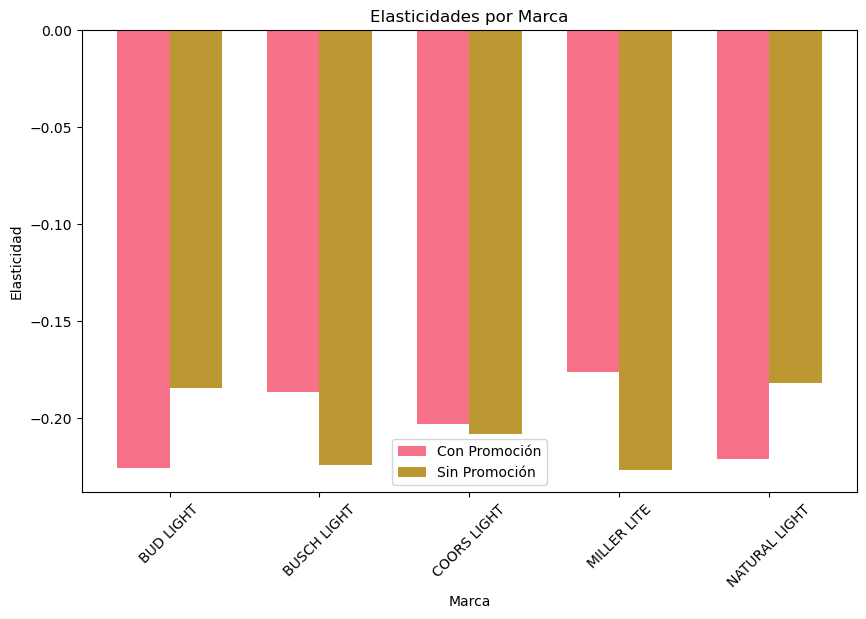

In [ ]:
# Genera dummies para la marca y estima las elasticidades de cada una de ellas cuando estan en promocion o no 
#Cual es la marca mas elastica? 

# Elasticidades por marca con/sin promoción

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression


brand_dummies = pd.get_dummies(df['beer_brand'], prefix='brand')


interaction_dummies = pd.DataFrame()
for brand in df['beer_brand'].unique():
    for promo in [True, False]:
        col_name = f'brand_{brand}_promo_{promo}'
        interaction_dummies[col_name] = ((df['beer_brand'] == brand) & (df['promotion'] == promo)).astype(int)


log_quantity = np.log(df['quantity'] + 0.01)
log_price = np.log(df['price_floz'] + 0.01)


X = pd.DataFrame({'log_price': log_price})
X = pd.concat([X, brand_dummies, interaction_dummies], axis=1)

model = LinearRegression()
model.fit(X, log_quantity)

print(f"R² del modelo: {model.score(X, log_quantity):.4f}")

base_elasticity = model.coef_[0]  
elasticities = {}

for brand in df['beer_brand'].unique():
    for promo in [True, False]:
        interaction_col = f'brand_{brand}_promo_{promo}'
        if interaction_col in X.columns:
            interaction_coef = model.coef_[X.columns.get_loc(interaction_col)]
            total_elasticity = base_elasticity + interaction_coef
            elasticities[f'{brand}_promo_{promo}'] = total_elasticity


print("\nElasticidades por marca:")
for brand in df['beer_brand'].unique():
    with_promo = elasticities.get(f'{brand}_promo_True', 0)
    without_promo = elasticities.get(f'{brand}_promo_False', 0)
    print(f"{brand}: Con promo {with_promo:.4f}, Sin promo {without_promo:.4f}")

most_elastic = min(elasticities.items(), key=lambda x: x[1])
print(f"\nMás elástica: {most_elastic[0]} ({most_elastic[1]:.4f})")

brands = df['beer_brand'].unique()
with_promo_vals = [elasticities.get(f'{brand}_promo_True', 0) for brand in brands]
without_promo_vals = [elasticities.get(f'{brand}_promo_False', 0) for brand in brands]

x = np.arange(len(brands))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, with_promo_vals, width, label='Con Promoción')
plt.bar(x + width/2, without_promo_vals, width, label='Sin Promoción')
plt.xlabel('Marca')
plt.ylabel('Elasticidad')
plt.title('Elasticidades por Marca')
plt.xticks(x, brands, rotation=45)
plt.legend()
plt.show()

In [16]:
# Crea una variable que si la marca es Bud Light que sea 1 y 0 si no. Llamala ybud y elabora una regresion logıstica con los datos demograficos. ¿Que score tiene?


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df['ybud'] = (df['beer_brand'] == 'BUD LIGHT').astype(int)
print(f"Distribución ybud: {df['ybud'].value_counts().to_dict()}")

demographic_vars = ['income', 'age', 'buyertype', 'employment', 'degree', 'ethnic']

df_demo = df.copy()
for var in demographic_vars:
    le = LabelEncoder()
    df_demo[var + '_encoded'] = le.fit_transform(df_demo[var])

features = [var + '_encoded' for var in demographic_vars]
X = df_demo[features]
y = df_demo['ybud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)


train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"\nAccuracy Train: {train_score:.4f}")
print(f"Accuracy Test: {test_score:.4f}")


coef_df = pd.DataFrame({
    'Variable': demographic_vars,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nImportancia variables:")
print(coef_df)

Distribución ybud: {0: 51523, 1: 21592}

Accuracy Train: 0.7043
Accuracy Test: 0.7064

Importancia variables:
     Variable  Coefficient
1         age    -0.202418
5      ethnic    -0.087409
2   buyertype    -0.027569
0      income    -0.010967
4      degree     0.007382
3  employment    -0.001607


Threshold óptimo: 0.3064

Con threshold 0.3064:
Sensibilidad (Recall): 0.4207
Especificidad: 0.6527
Precisión: 0.3348
F1-Score: 0.3729

Comparación threshold 0.5:
Sensibilidad: 0.0000
Especificidad: 1.0000


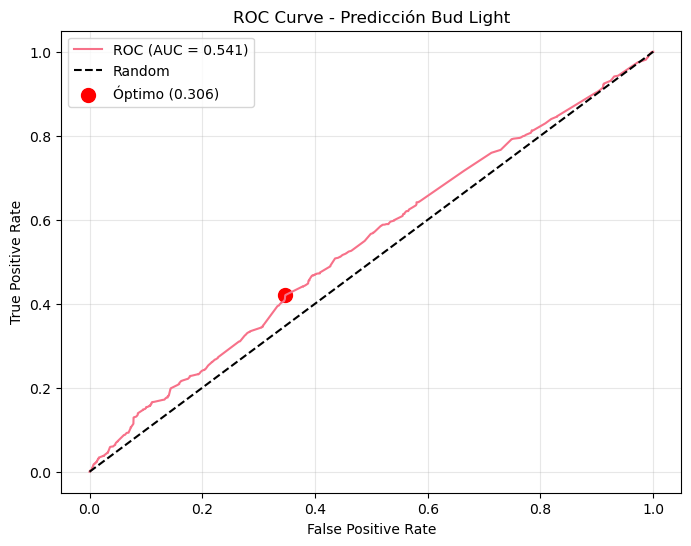

In [17]:
# 4. ¿Cual es el threshold optimo para este modelo? Indica la sensibilidad y la especificidad del modelo.
# Threshold óptimo para modelo logístico Bud Light

from sklearn.metrics import roc_curve, confusion_matrix, classification_report
import numpy as np

y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print(f"Threshold óptimo: {optimal_threshold:.4f}")

y_pred_optimal = (y_probs >= optimal_threshold).astype(int)


cm = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()


sensitivity = tp / (tp + fn)  
specificity = tn / (tn + fp)  
precision = tp / (tp + fp)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

print(f"\nCon threshold {optimal_threshold:.4f}:")
print(f"Sensibilidad (Recall): {sensitivity:.4f}")
print(f"Especificidad: {specificity:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

y_pred_default = (y_probs >= 0.5).astype(int)
cm_default = confusion_matrix(y_test, y_pred_default)
tn_def, fp_def, fn_def, tp_def = cm_default.ravel()

sens_default = tp_def / (tp_def + fn_def)
spec_default = tn_def / (tn_def + fp_def)

print(f"\nComparación threshold 0.5:")
print(f"Sensibilidad: {sens_default:.4f}")
print(f"Especificidad: {spec_default:.4f}")


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {np.trapz(tpr, fpr):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, label=f'Óptimo ({optimal_threshold:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Predicción Bud Light')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Influencia de variables (por coeficiente absoluto):
     Variable  Coefficient
1         age    -0.202418
5      ethnic    -0.087409
2   buyertype    -0.027569
0      income    -0.010967
4      degree     0.007382
3  employment    -0.001607

Variable más influyente: age
Coeficiente: -0.2024
Efecto: DISMINUYE la probabilidad de elegir Bud Light


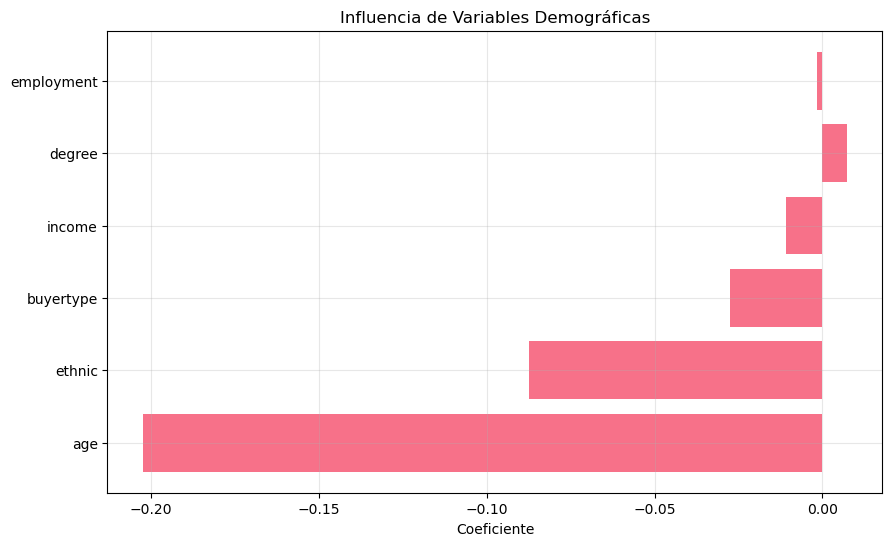

In [19]:
# 5. ¿Que variable influye mas en el modelo?



coef_df = pd.DataFrame({
    'Variable': demographic_vars,
    'Coefficient': model.coef_[0],
    'Abs_Coefficient': np.abs(model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("Influencia de variables (por coeficiente absoluto):")
print(coef_df[['Variable', 'Coefficient']])

most_influential = coef_df.iloc[0]['Variable']
most_coef = coef_df.iloc[0]['Coefficient']

print(f"\nVariable más influyente: {most_influential}")
print(f"Coeficiente: {most_coef:.4f}")

if most_coef > 0:
    print("Efecto: AUMENTA la probabilidad de elegir Bud Light")
else:
    print("Efecto: DISMINUYE la probabilidad de elegir Bud Light")

# Gráfico simple
plt.figure(figsize=(10, 6))
plt.barh(range(len(coef_df)), coef_df['Coefficient'])
plt.yticks(range(len(coef_df)), coef_df['Variable'])
plt.xlabel('Coeficiente')
plt.title('Influencia de Variables Demográficas')
plt.grid(alpha=0.3)
plt.show()

Variables más importantes (SHAP):
     Variable  SHAP_Importance
1         age         0.116305
5      ethnic         0.054202
2   buyertype         0.016947
0      income         0.012897
4      degree         0.006207
3  employment         0.000806

Variable que más explica Bud Light: age


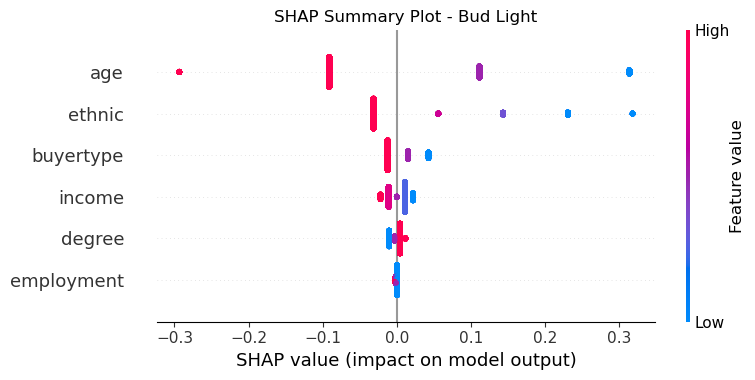

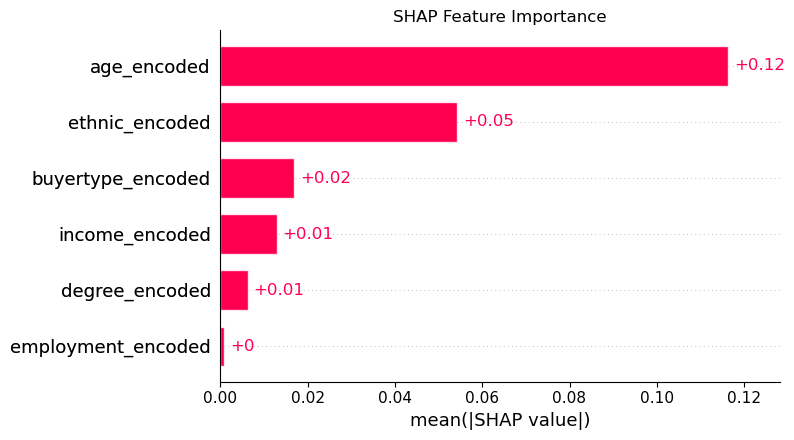


Comparación métodos:
              Variable  Coeficiente  SHAP_Importance
Variable                                            
age                age     0.202418         0.116305
ethnic          ethnic     0.087409         0.054202
buyertype    buyertype     0.027569         0.016947
income          income     0.010967         0.012897
degree          degree     0.007382         0.006207
employment  employment     0.001607         0.000806


In [23]:

import shap
import pandas as pd



explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap_importance = pd.DataFrame({
    'Variable': demographic_vars,
    'SHAP_Importance': np.abs(shap_values.values).mean(0)
}).sort_values('SHAP_Importance', ascending=False)

print("Variables más importantes (SHAP):")
print(shap_importance)

most_important = shap_importance.iloc[0]['Variable']
print(f"\nVariable que más explica Bud Light: {most_important}")

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=demographic_vars, show=False)
plt.title("SHAP Summary Plot - Bud Light")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
shap.plots.bar(shap_values, show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

comparison = pd.DataFrame({
    'Variable': demographic_vars,
    'Coeficiente': np.abs(model.coef_[0]),
    'SHAP_Importance': shap_importance.set_index('Variable').loc[demographic_vars, 'SHAP_Importance']
})

print(f"\nComparación métodos:")
print(comparison.sort_values('SHAP_Importance', ascending=False))